In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import networkx as nx

# Model details:

This model assumes that person j becomes infected accoriding to the sum of poisson processes that model passing infection from someone that the person interacts with. The propensity of these poisson processes is determined by the weight of the social edge between two people - roughly how often they interact. 

The edge weights of the social network change dynamically - they weaken for infected people. Edge weights overall can be set to react to total infected. 

# Simulation:

For anyone who gets sick, we need to pick some parameters for their future interaction.

In [3]:
def pick_params(glob = 1):
    severity = np.random.normal(loc=0.5, scale=0.2)#could of course change this distribution
    if severity < 0.1:
        severity = 0.1
    if severity > 1:
        severity = 1
    personality = np.random.normal(loc=0.5, scale=0.2)#could of course change this distribution
    if personality < 0.1:
        personality = 0.1
    if personality > 1:
        personality = 1
    m = (1-severity)*0.4*glob*(1-personality) #minimum social behavior depends on severity & "city" & personality
    l = 5*severity*personality #speed of reaction depends on severity and "personality"
    s = np.random.normal(loc=2.5, scale=0.5) #delay in symptom/reaction is random
    if s < 0.2:
        s = 0.2
    revover_or_die = (1.4*(severity - 0.5))**2 + 0.3 #high severity - die faster. Low severity - recover faster
    
    return [m,l,s],revover_or_die
    

We scale social interactions accoriding to a non-linear response to illness.

In [4]:
def dyweight(strtw,ti,i_params):
    flr,lag,slp = i_params
    return strtw*((1-flr)/(1 + (lag*ti)**(slp)) + flr)

In [5]:
def adjt(adj,tk,infc_params):
    N = adj.shape[0]
    tadj = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            if tk[j] ==0 and tk[i] ==0:
                weight = adj[i,j]
            else:
                weight = min(dyweight(adj[i,j],tk[i],infc_params[i]),dyweight(adj[i,j],tk[j],infc_params[j]))
            tadj[i,j] = weight
            tadj[j,i] = weight
    return tadj

Part of the Gillespie sim.

In [6]:
def pick_jump(infectednow,adj,tk,recov,lam0,infc_params):
    U = np.random.rand()
    props = adjt(adj,tk,infc_params)*infectednow
    chs_jmp = []
    chs_person = np.sum(props,axis = 1)
    qs = [chs_person[0]]
    for i in range(1,N):
        qs += [qs[i-1] + chs_person[i]]
    qs = np.array(qs)/lam0
    if U > qs[-1]:
        reqs = [qs[-1]+infectednow[0]*recov[0]/lam0]
        for i in range(1,N):
            reqs += [reqs[i-1] + infectednow[i]*recov[i]/lam0]
        reqs = np.array(reqs)
        if U > reqs[-1]:
            return 0
        else:
            recovered = np.where(np.sort(np.append(reqs,U))==U)[0][0] + 1
            return -recovered
    else:
        infected_one = np.where(np.sort(np.append(qs,U))==U)[0][0] + 1
        return infected_one
            
    

Gillespie simulation that returns detailed outbreak simulation

In [7]:
def simulate_outbreak(init_infected,social_net,endt,reinfect_prob = 0,social_d = 0):
    N = len(social_net)
    infc_params = [[1,1,1]]*N
    recprops = np.zeros(N)
    jump_times = np.array([0])
    rljumps = np.array([0])
    infected_times = np.zeros(N)
    all_inf_times = [infected_times]
    status = [init_infected.copy()]
    cur_social_net = social_net.copy()
    
    all_infc_params = [infc_params]
    
    
    while (jump_times[-1] < endt):
        infected = np.maximum(status[-1],np.zeros(N))
        
        if social_d:
            tot_infc = np.sum(infected)/N
            cur_social_net = social_net.copy() * (np.ones(social_net.shape)-tot_infc*social_d*np.random.rand(*social_net.shape))
            
        lam0 = np.sum(cur_social_net*infected) + sum(recprops*infected)
        if lam0:
            dt = np.random.exponential(1/lam0)
            jump_times = np.append(jump_times,jump_times[-1] + dt)
            infected_times = infected_times + dt*infected
            all_inf_times += [infected_times]
            jmp = pick_jump(infected,cur_social_net,infected_times,recprops,lam0,infc_params)
            new_status = status[-1].copy()
            if jmp>0:
                if new_status[jmp-1] == 0:
                    new_status[jmp - 1] = 1
                    rljumps = np.append(rljumps,len(jump_times) -1)
                    distp,recv = pick_params()
                    infc_params[jmp-1] = distp
                    recprops[jmp-1] = recv
                else:
                    reinfect = np.random.rand()
                    if reinfect > (1-reinfect_prob):
                        new_status[jmp - 1] = 1
                        rljumps = np.append(rljumps,len(jump_times) -1)
                        distp,recv = pick_params()
                        infc_params[jmp-1] = distp
                        recprops[jmp-1] = recv
            elif jmp < 0:
                new_status[-jmp - 1] = -1
                rljumps = np.append(rljumps,len(jump_times) -1)
            status += [new_status]
            all_infc_params += [infc_params]
        else:
            status = status + [status[-1]]
            jump_times = np.append(jump_times,endt)
            rljumps = np.append(rljumps,len(jump_times) - 1)
            all_infc_params += [all_infc_params[-1]]
                    
        
    return jump_times,rljumps,np.array(status),np.array(all_inf_times),all_infc_params
        
    
    
    

Simulation that does not track details (for sampling).

In [121]:
def sim_outbreak_lite(init_infected,social_net,endt,reinfect_prob = 0,social_d = 0):
    N = len(social_net)
    infc_params = [[1,1,1]]*N
    recprops = np.zeros(N)
    jump_times = np.array([0])
    rljumps = np.array([0])
    infected_times = np.zeros(N)
    status = init_infected.copy()
    total_infctd = np.array([np.sum(init_infected)])
    
    cur_social_net = social_net.copy()
    
    
    while (jump_times[-1] < endt):
        infected = np.maximum(status,np.zeros(N))
        
        if social_d:
            tot_infc = np.sum(infected)/N
            sclmat = np.ones(social_net.shape)*(2/(1+tot_infc**(0.5/social_d)) - 1)
            cur_social_net = social_net.copy() * sclmat
        
        
        lam0 = np.sum(cur_social_net*infected) + sum(recprops*infected)
        if lam0:
            dt = np.random.exponential(1/lam0)
            jump_times = np.append(jump_times,jump_times[-1] + dt)
            infected_times = infected_times + dt*infected
            jmp = pick_jump(infected,cur_social_net,infected_times,recprops,lam0,infc_params)
            new_status = status.copy()
            if jmp>0:
                if new_status[jmp-1] == 0:
                    new_status[jmp - 1] = 1
                    rljumps = np.append(rljumps,len(jump_times) -1)
                    distp,recv = pick_params()
                    infc_params[jmp-1] = distp
                    recprops[jmp-1] = recv
                else:
                    reinfect = np.random.rand()
                    if reinfect > (1-reinfect_prob):
                        new_status[jmp - 1] = 1
                        rljumps = np.append(rljumps,len(jump_times) -1)
                        distp,recv = pick_params()
                        infc_params[jmp-1] = distp
                        recprops[jmp-1] = recv
            elif jmp < 0:
                new_status[-jmp - 1] = -1
                rljumps = np.append(rljumps,len(jump_times) -1)
                
            new_infected = np.maximum(new_status,np.zeros(N))   
            status = new_status
            total_infctd = np.append(total_infctd,np.sum(new_infected))


        else:
            total_infctd = np.append(total_infctd,total_infctd[-1])
            jump_times = np.append(jump_times,endt)
            rljumps = np.append(rljumps,len(jump_times) - 1)
                
    return jump_times,rljumps,np.array(total_infctd)

Here, we build the initial social network. The following cell plots it. This is an Erdos-Reyni random graph.

In [67]:
N = 50
p = 0.18

G = nx.fast_gnp_random_graph(N,p)


a1 = nx.to_numpy_array(G)
b1 = np.random.rand(*a1.shape)
a = a1*(b1 + b1.T)/2
            
init = np.zeros(N)
init[2] = 1

Or we can use a scale-free network:

In [114]:
N = 50
m = 2

G = nx.barabasi_albert_graph(N,3)

a1 = nx.to_numpy_array(G)
b1 = np.random.rand(*a1.shape)
a = a1*(b1 + b1.T)/2
            
init = np.zeros(N)
init[2] = 1

Or a "small world" graph

In [75]:
N = 50
k = 4
p = 0.3

G = nx.watts_strogatz_graph(N,k,p)

a1 = nx.to_numpy_array(G)
b1 = np.random.rand(*a1.shape)
a = a1*(b1 + b1.T)/2
            
init = np.zeros(N)
init[2] = 1

Other graph generaters can be found at https://networkx.github.io/documentation/stable/reference/generators.html

To plot with circle:

In [71]:
degs = [i*2*np.pi/N for i in range(N)]
node_pos = [np.array([np.cos(d),np.sin(d)]) for d in degs]

To plot using other positions:

In [81]:
node_pos = list(nx.kamada_kawai_layout(nx.from_numpy_array(a)).values())

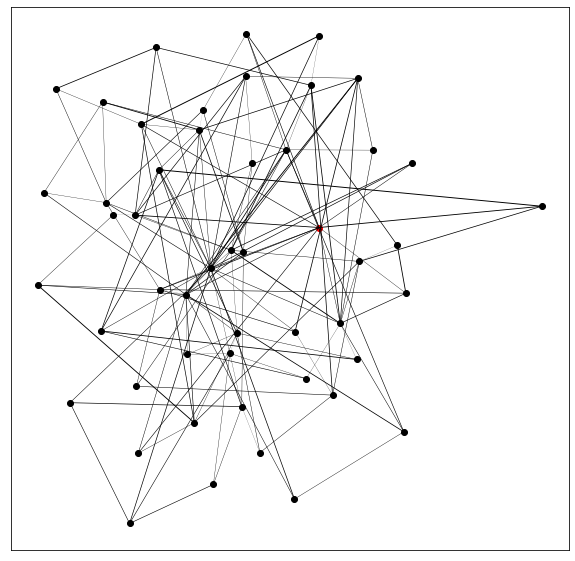

In [82]:
fig,ax = plt.subplots(1,figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.scatter([node_pos[i][0] for i in range(N) if init[i] ==0],[node_pos[i][1] for i in range(N) if init[i] == 0],color = 'k')
ax.scatter([node_pos[i][0] for i in range(N) if init[i]],[node_pos[i][1] for i in range(N) if init[i] ],color = 'r')
for i in range(N):
    for j in range(i,N):
        if a[i,j] != 0:
            ax.plot([node_pos[i][0],node_pos[j][0]],[node_pos[i][1],node_pos[j][1]], color = 'black',linewidth=a[i,j])

In [83]:
jmp_times,jmp_indices,total_inf = sim_outbreak_lite(init,a,20,social_d = 0)

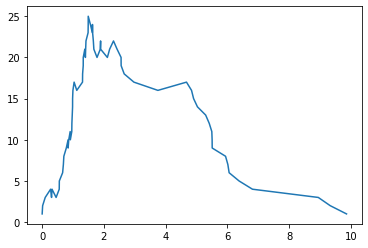

In [84]:
plt.plot(jmp_times[jmp_indices],total_inf[jmp_indices])

In [50]:
all_jmps,event_indices,status,inf_times,infc_params = simulate_outbreak(init,a,10,social_d = 0.5)

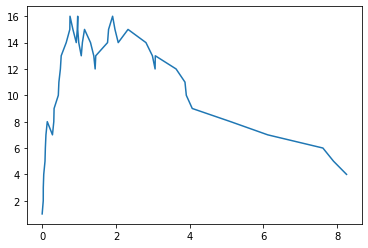

In [51]:
plt.plot(all_jmps[event_indices],[sum(np.maximum(inf,np.zeros(N))) for inf in status[event_indices]])

We can create a .gif of the social interaction strengths across the duration of the infection

In [53]:
def plot_social_net(t,inft_times,jump_times,statuses,intial_net,infc_params,node_pos,social_d = 0):
    N = len(statuses[0])

    befo = np.where(np.sort(np.append(jump_times,t)) == t)[0][0]
    
    if befo >= len(inft_times):
        befo = len(inft_times) -1
    
    infected = np.maximum(np.zeros(N),statuses[befo])
    
    if social_d:
        tot_infc = np.sum(infected)/N
        cur_social_net = social_net.copy() * (np.ones(social_net.shape)-tot_infc*social_d*np.random.rand(*social_net.shape))

    
    
    tk = inft_times[befo] + (t-jump_times[befo])*infected
    
    infc_paramst = infc_params[befo]
    
    net_now = adjt(intial_net,tk,infc_paramst)
    
    fig,ax = plt.subplots(1,figsize = (10,10))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.scatter([node_pos[i][0] for i in range(N) if infected[i] ==0],[node_pos[i][1] for i in range(N) if infected[i] == 0],color = 'k')
    ax.scatter([node_pos[i][0] for i in range(N) if infected[i]],[node_pos[i][1] for i in range(N) if infected[i]],color = 'r')
    for i in range(N):
        for j in range(i,N):
            if net_now[i,j] != 0:
                ax.plot([node_pos[i][0],node_pos[j][0]],[node_pos[i][1],node_pos[j][1]], color = 'black',linewidth=3*net_now[i,j])
            
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close()
    
    return image

In [54]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('net.gif', [plot_social_net(t, inf_times,all_jmps,status,a,infc_params,node_pos) for t in np.linspace(0,8,50)], fps=10)

/Users/m197894/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
def sample_outbreak(gtype,N,mean_deg ,simlength = 10,social_d = 0):
    #build random social network
    if gtype == "ER":
        p = 2*mean_deg/N
        

        G = nx.fast_gnp_random_graph(N,p)


        a1 = nx.to_numpy_array(G)
        b1 = np.random.rand(*a1.shape)
        a = a1*(b1 + b1.T)/2

        
    elif gtype == "BA": 
        
        m = mean_deg
        
        G = nx.barabasi_albert_graph(N,m)

        a1 = nx.to_numpy_array(G)
        b1 = np.random.rand(*a1.shape)
        a = a1*(b1 + b1.T)/2
        
    elif gtype == "SW":
        k = 2*mean_deg
        p = 0.5

        G = nx.watts_strogatz_graph(N,k,p)

        a1 = nx.to_numpy_array(G)
        b1 = np.random.rand(*a1.shape)
        a = a1*(b1 + b1.T)/2

            
    init = np.zeros(N)
    init[2] = 1
    
    mean_deg = np.sum(a)/N
    
    jmp_times,jmp_indices,total_inf = sim_outbreak_lite(init,a,simlength,social_d = social_d)
    
    max_inf = max(total_inf)
    
    return mean_deg, max_inf, total_inf[jmp_indices]
        

Sample Erdos-Reyne (ER) graphs, Power-law (BA) graph, or "Small World" (SW) graphs.

In [88]:
md, mi, sim = sample_outbreak("ER",50,6)

In [89]:
md,mi

(5.8853023174577155, 36.0)

In [122]:
many_sims = []
many_times = []
for i in range(50):
    jmp_times,jmp_indices,total_inf = sim_outbreak_lite(init,a,10,social_d = 0)
    many_sims += [total_inf[jmp_indices]]
    many_times += [jmp_times[jmp_indices]]

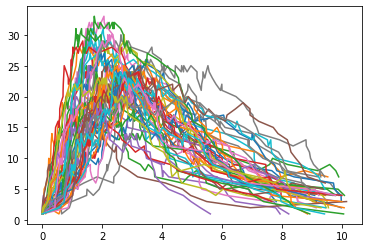

In [123]:
fig2,ax2 = plt.subplots(1)
for i in range(50):
    ax2.plot(many_times[i],many_sims[i])


Now let's sample 100 of each type of random graph with 50 nodes and mean degree about 6.

In [125]:
er_samples = []
er_degs = []
for i in range(100):
    md, mi, sim = sample_outbreak("ER",50,6 ,simlength = 10,social_d = 0)
    er_samples += [mi]
    er_degs += [md]
    
ab_samples = []
ab_degs = []
for i in range(100):
    md, mi, sim = sample_outbreak("BA",50,6 ,simlength = 10,social_d = 0)
    ab_samples += [mi]
    ab_degs += [md]
    
sw_samples = []
sw_degs = []
for i in range(100):
    md, mi, sim = sample_outbreak("SW",50,6 ,simlength = 10,social_d = 0)
    sw_samples += [mi]
    sw_degs += [md]

(array([ 3.,  3.,  4., 13., 18., 16., 25., 13.,  3.,  2.]),
 array([27., 29., 31., 33., 35., 37., 39., 41., 43., 45., 47.]),
 <a list of 10 Patch objects>)

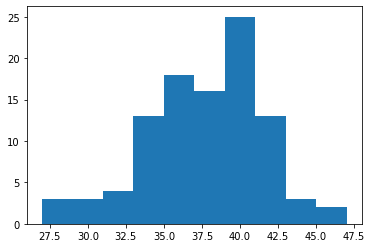

In [126]:
plt.hist(er_samples)

(array([ 1.,  1.,  2.,  4., 18., 14., 25., 21., 11.,  3.]),
 array([24. , 25.9, 27.8, 29.7, 31.6, 33.5, 35.4, 37.3, 39.2, 41.1, 43. ]),
 <a list of 10 Patch objects>)

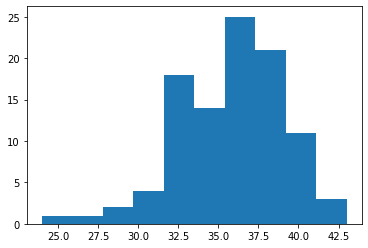

In [127]:
plt.hist(ab_samples)

(array([ 1.,  5., 17.,  6., 19.,  9., 25.,  9.,  4.,  5.]),
 array([31. , 32.5, 34. , 35.5, 37. , 38.5, 40. , 41.5, 43. , 44.5, 46. ]),
 <a list of 10 Patch objects>)

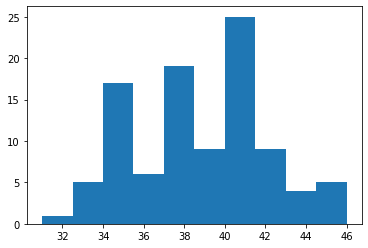

In [128]:
plt.hist(sw_samples)